In [1]:

import numpy as np
import pandas as pd
import data_lib
import plot_lib
import transform_lib
import decision_lib
from sklearn import cluster

np.random.seed(200)

In [2]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13               

### Get samples for negative control

In [3]:
# negative control
#df_negative_control = data_lib.load_dataset([],["po-di-se-1-D1", "po-di-se-1-D4", "po-di-se-2-D1", "po-di-se-2-D4", "po-di-se-D8"])
df_negative_control = data_lib.load_dataset([],["wa-sa-D3", "wa-sa-D5"], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
df_y_negative_control = pd.DataFrame(np.zeros(df_negative_control.shape[0]))

In [4]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                     #"wa-sa-A2", "wa-sa-B4",
                                     #"wa-sa-C5", "wa-sa-C4",
                                     "wa-sa-B3", "wa-sa-B2",
                                     #"wa-sa-A5", "wa-sa-A3",
                                     #"wa-sa-C2", "wa-sa-C3",
                                     #"wa-sa-D3", "wa-sa-D4", 
                                     #"wa-sa-B1", "wa-sa-A4",
                                     #"wa-sa-A1", "wa-sa-D2",
                                     #"wa-sa-D5", "wa-sa-C1",
                                     ], datafolder="../../Data")
np_wa = df_wa.to_numpy(copy=True)[:,:6]
ZCA_whitener = transform_lib.WhitenTransformer(transform_lib.Whitenings.ZCA_COR)

In [5]:
# fix clustering algorithm
cluster_engine = cluster.DBSCAN(eps = 1000, min_samples = 1, n_jobs=8)

# initialize desion maker based on negative control cluster and defined some settings
neg_cluster_based_classifier = decision_lib.NegativeClusterBasedClassifier(negative_cluster=np_negative_control,
                                            cluster_algorithm=cluster_engine,
                                            aggressiveness=[7,17, 30, 15, 15, 19],
                                            whitening_transformer=ZCA_whitener,
                                            prediction_axis=['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
                                            )

# fit the whitening transformer and compute thresholds for negative control culster
neg_cluster_based_classifier.fit(np_wa)

# predict does not scale well due to clustering inside
df_predictions = neg_cluster_based_classifier.predict(np_wa, cluster_on_transformed=False)

# Validation

## Get some (not very usefull) stats
Most points are simply negatives

In [6]:
neg_cluster_based_classifier.validate_labels(df_wa.iloc[:,6:])

Total error rate: 0.006953408955661146
Total error per class:
    SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS   MHV_POS
0       0.0039     0.002747    0.01431        0.0   0.002719  0.018045


False negative rate: 0.003483570911954004
False negative rate per class:
    SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS   MHV_POS
0          0.0          0.0    0.01431        0.0   0.002719  0.003873


False positive rate: 0.003469838043707142
False negative rate per class:
    SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS   MHV_POS
0       0.0039     0.002747        0.0        0.0        0.0  0.014172




## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot SARS-N2_POS associated with channel 1

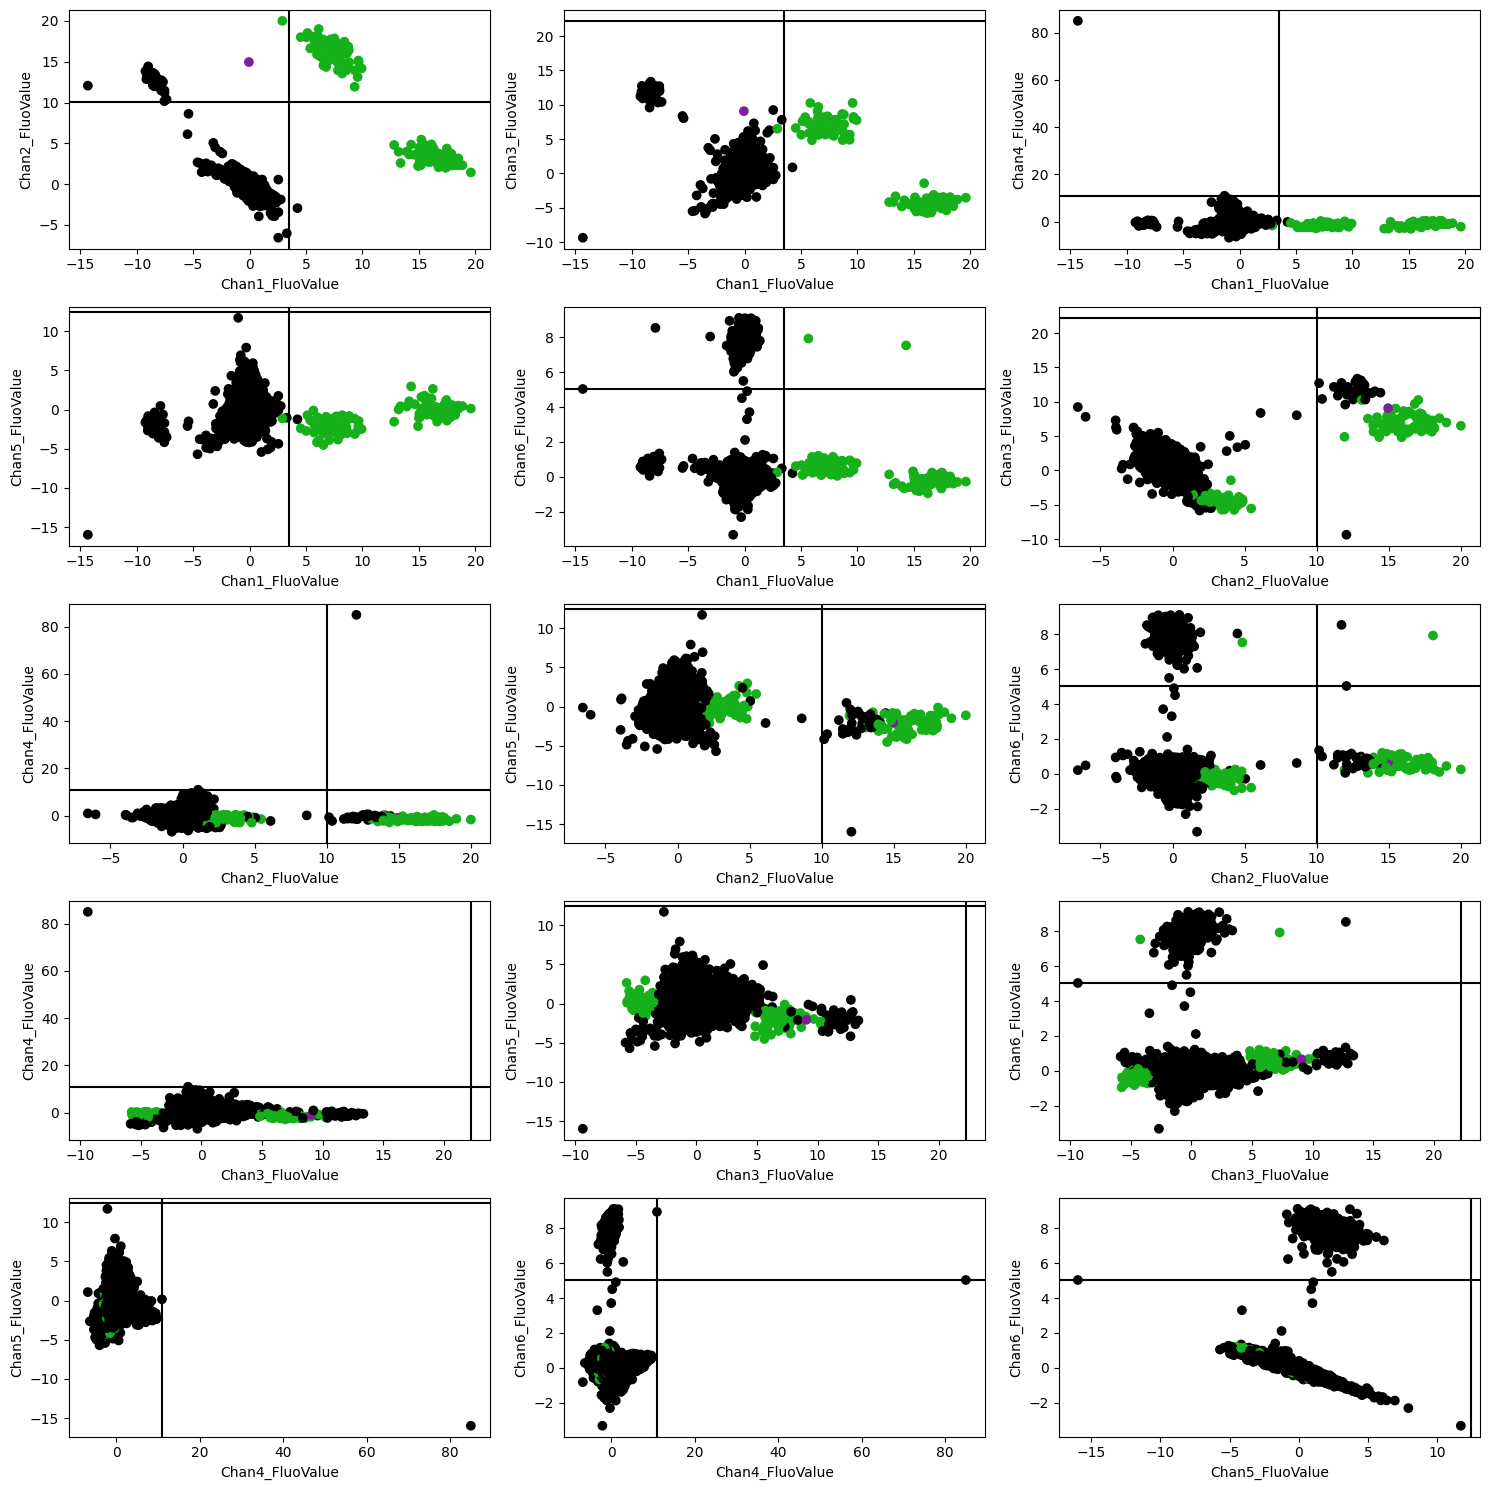

In [7]:
plot_lib.pairwise_plots_pred_true_thresh(pd.DataFrame(data=neg_cluster_based_classifier.X_transformed, columns=df_wa.iloc[:,:6].columns),
                                         df_predictions["SARS-N2_POS"],
                                         df_wa.loc[:,"SARS-N2_POS"],
                                         axis_thresh=neg_cluster_based_classifier.axis_threshholds)

#### Plot SARS-N1_POS associated with cannel 2

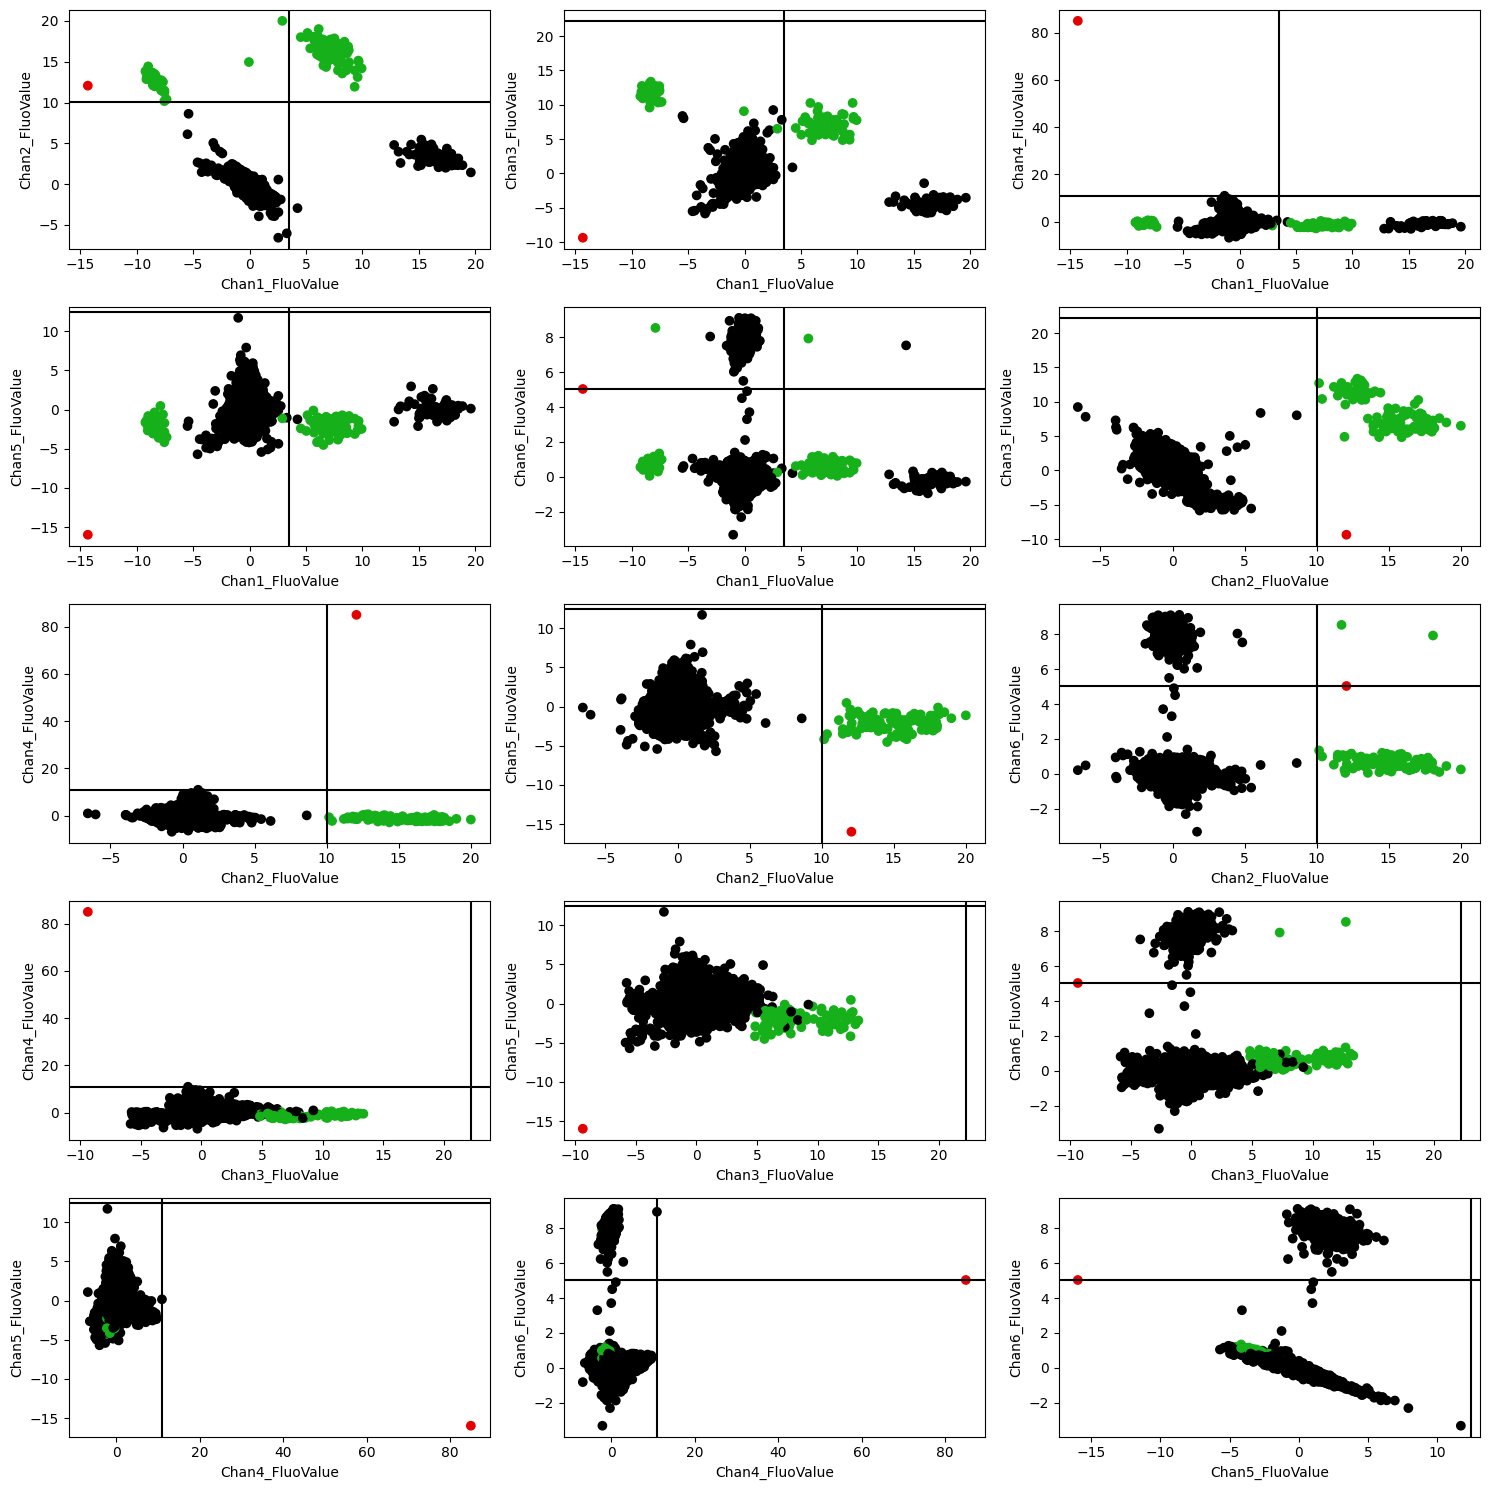

In [8]:
plot_lib.pairwise_plots_pred_true_thresh(pd.DataFrame(data=neg_cluster_based_classifier.X_transformed, columns=df_wa.iloc[:,:6].columns),
                                  df_predictions["SARS-N1_POS"],
                                  df_wa.loc[:,"SARS-N1_POS"],
                                  axis_thresh=neg_cluster_based_classifier.axis_threshholds
                                  )

#### Plot IBV-M_POS associated with cannel 3

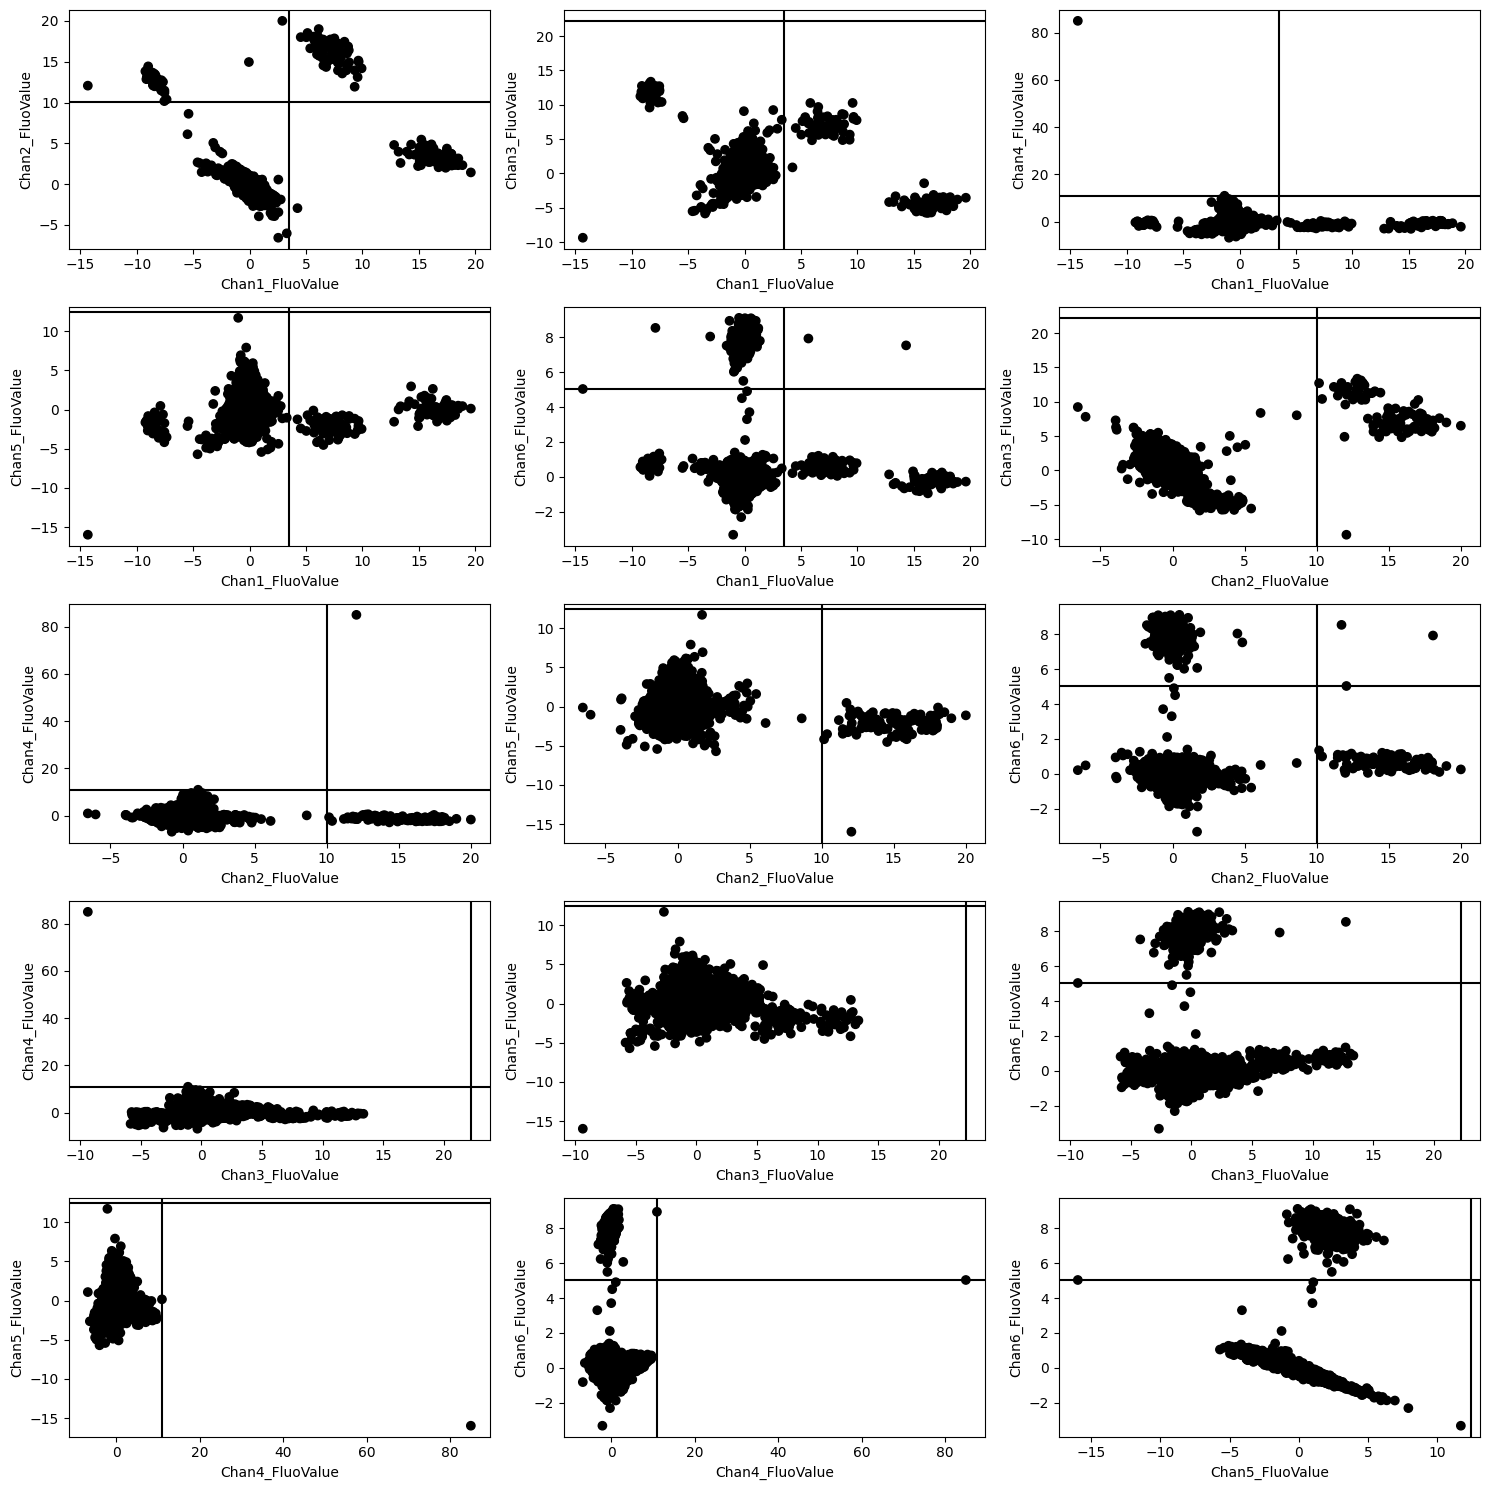

In [9]:
plot_lib.pairwise_plots_pred_true_thresh(pd.DataFrame(data=neg_cluster_based_classifier.X_transformed, columns=df_wa.iloc[:,:6].columns),
                                         df_predictions["IBV-M_POS"],
                                         df_wa.loc[:,"IBV-M_POS"],
                                         axis_thresh=neg_cluster_based_classifier.axis_threshholds,
                                         )

#### Plot RSV-N_POS associated with cannel 4

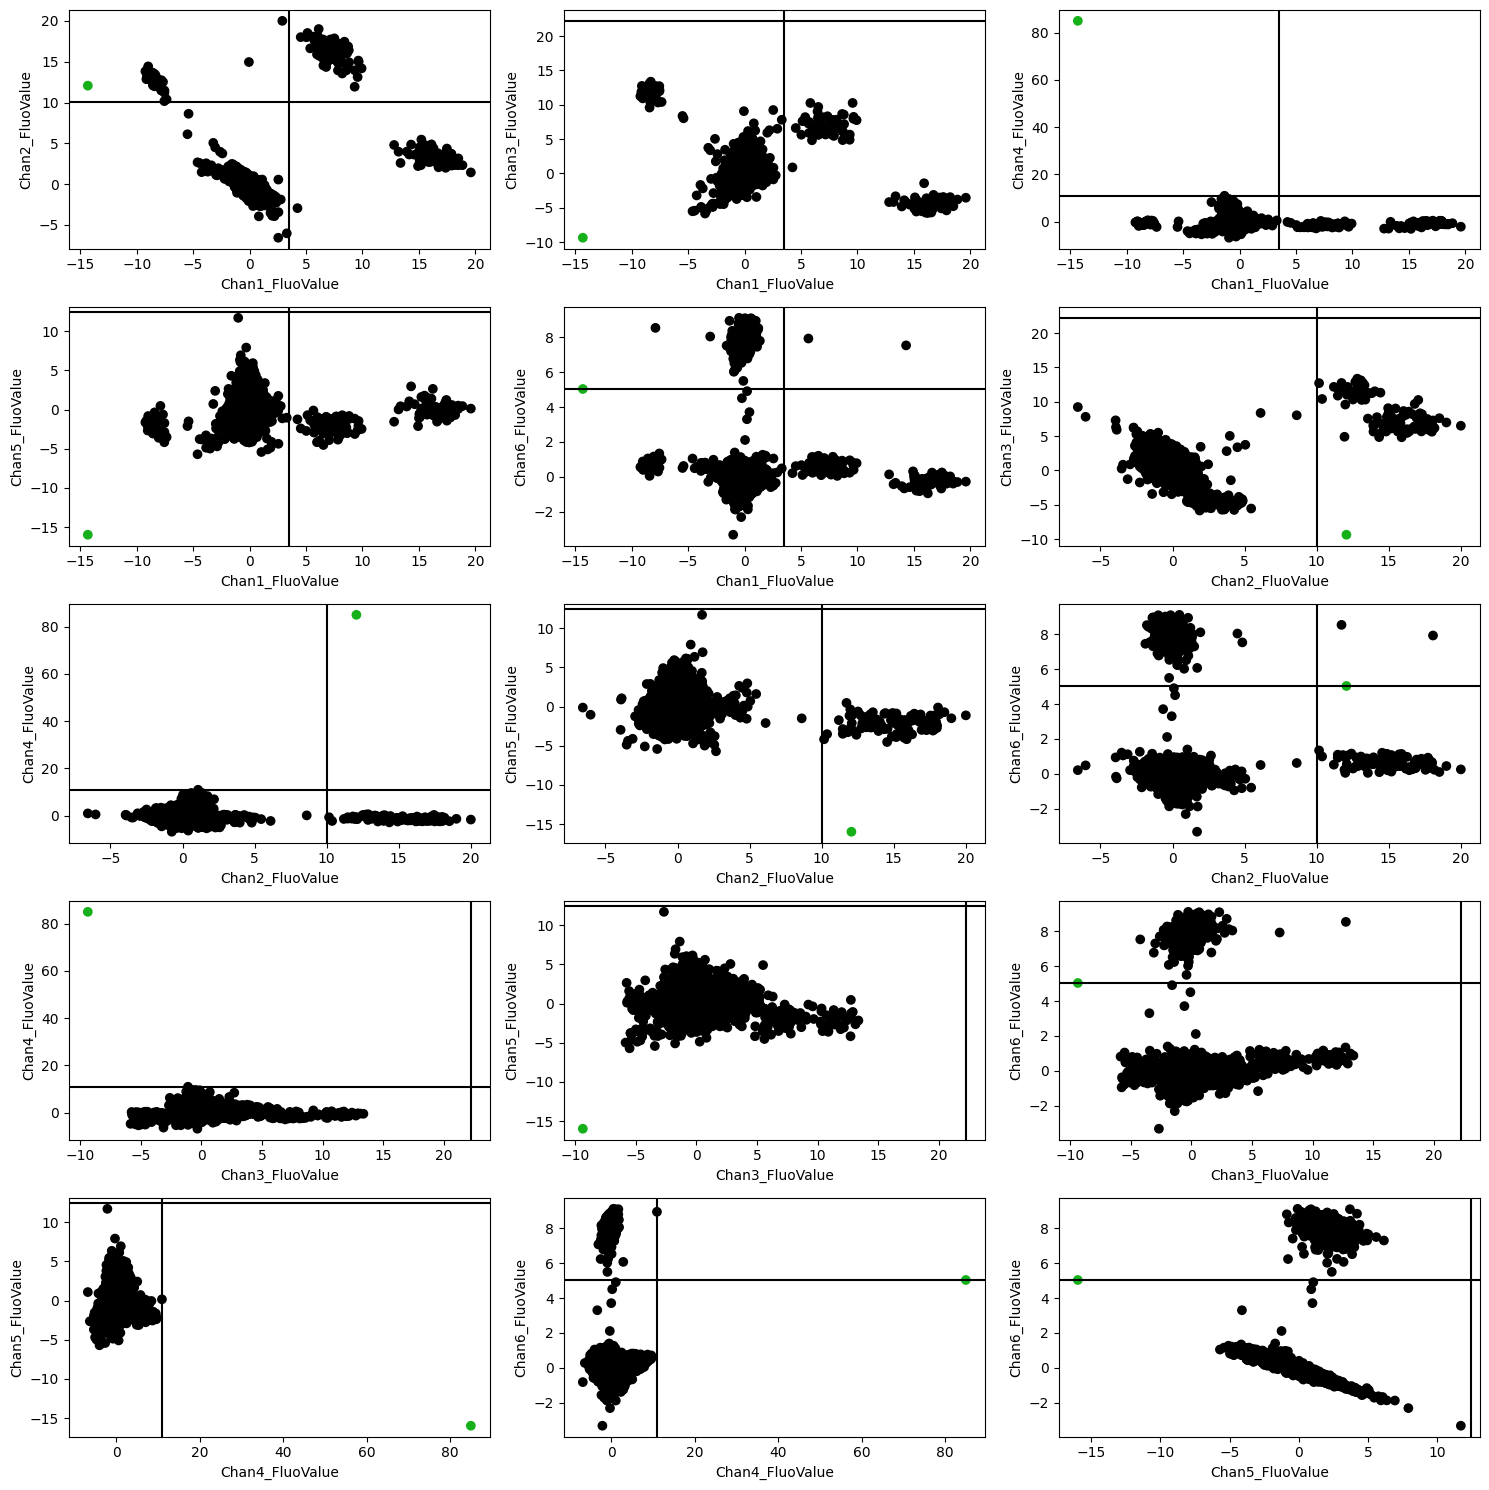

In [10]:
plot_lib.pairwise_plots_pred_true_thresh(pd.DataFrame(data=neg_cluster_based_classifier.X_transformed, columns=df_wa.iloc[:,:6].columns),
                                         df_predictions["RSV-N_POS"],
                                         df_wa.loc[:,"RSV-N_POS"],
                                         axis_thresh=neg_cluster_based_classifier.axis_threshholds,
                                         )

#### Plot IAV-M_POS associated with cannel 5

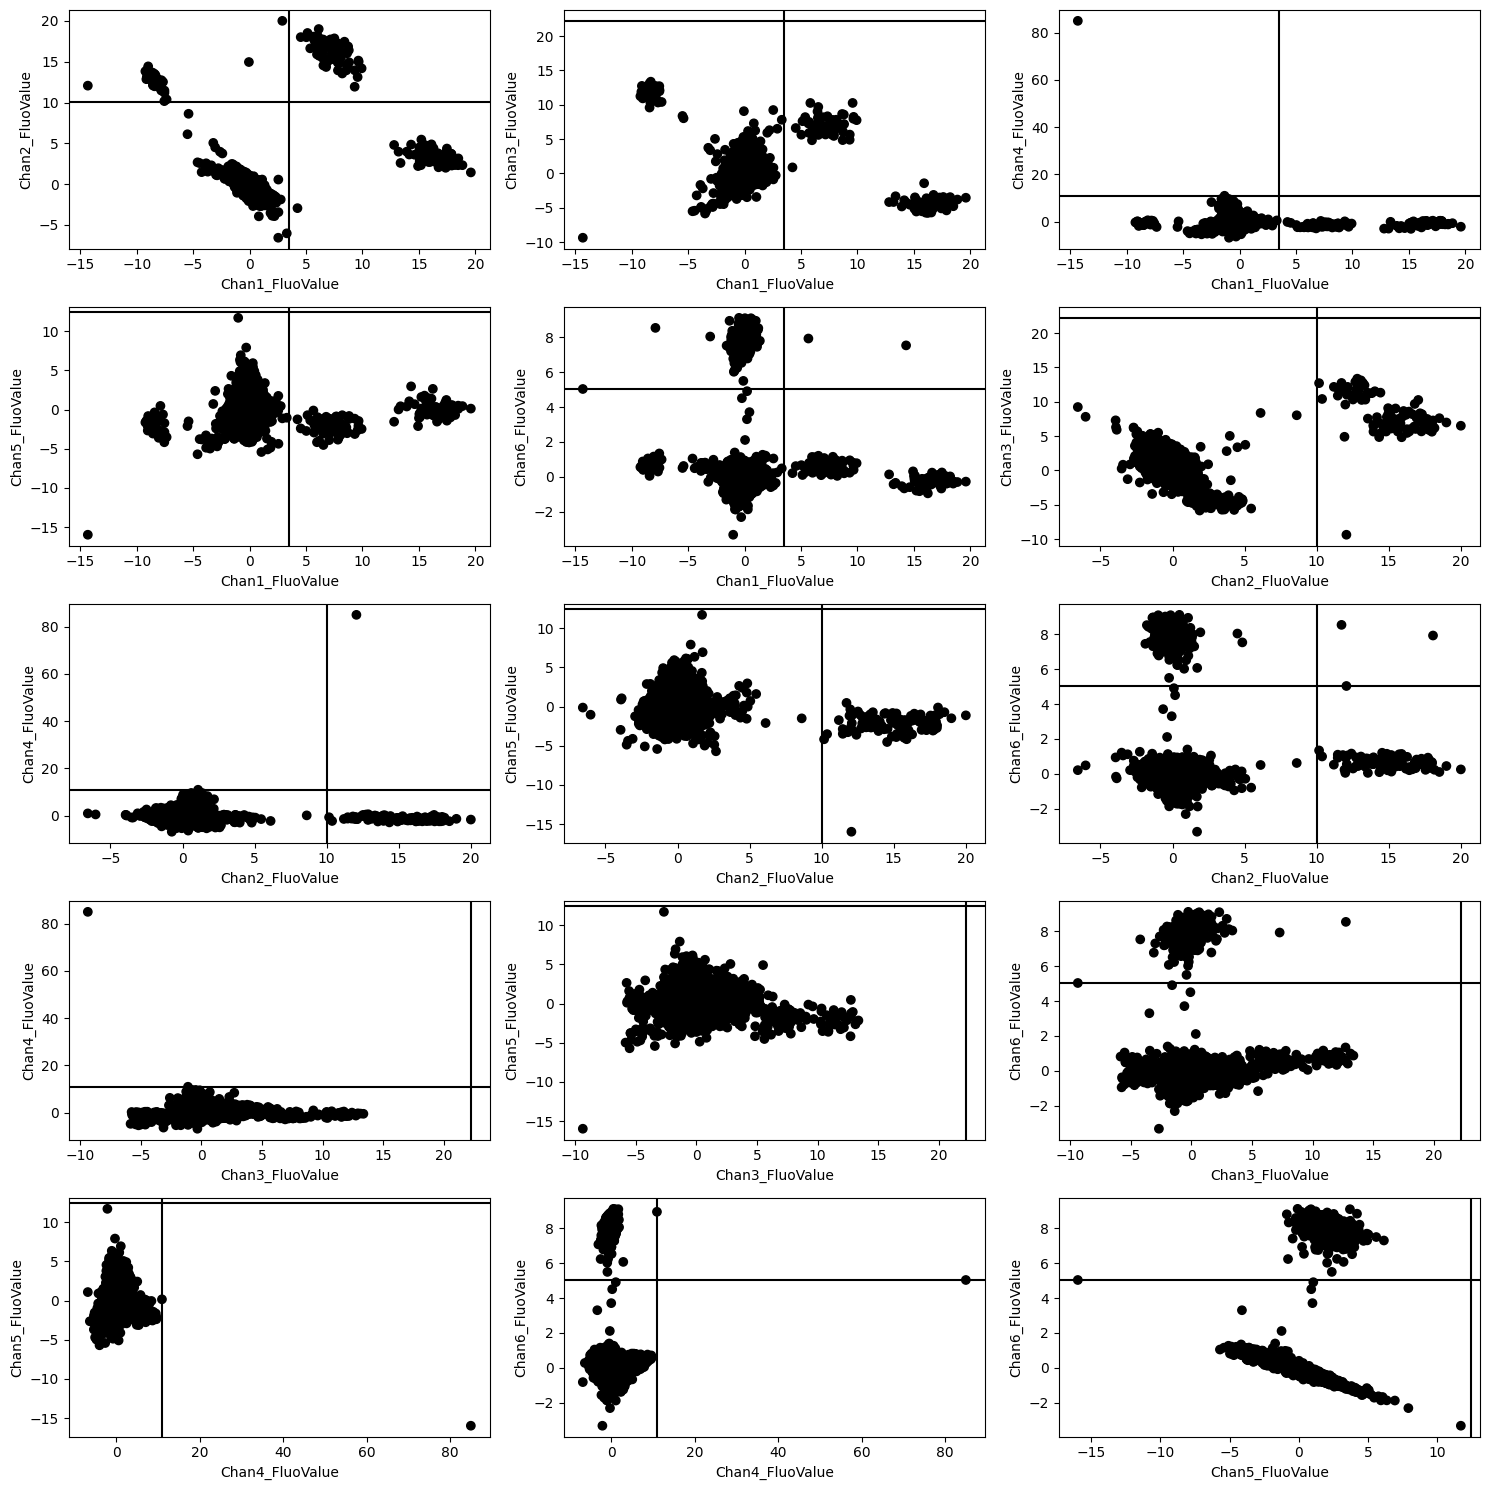

In [11]:
plot_lib.pairwise_plots_pred_true_thresh(pd.DataFrame(data=neg_cluster_based_classifier.X_transformed, columns=df_wa.iloc[:,:6].columns),
                                         df_predictions["IAV-M_POS"],
                                         df_wa.loc[:,"IAV-M_POS"],
                                         axis_thresh=neg_cluster_based_classifier.axis_threshholds,
                                         )

#### Plot MHV_POS associated with cannel 6

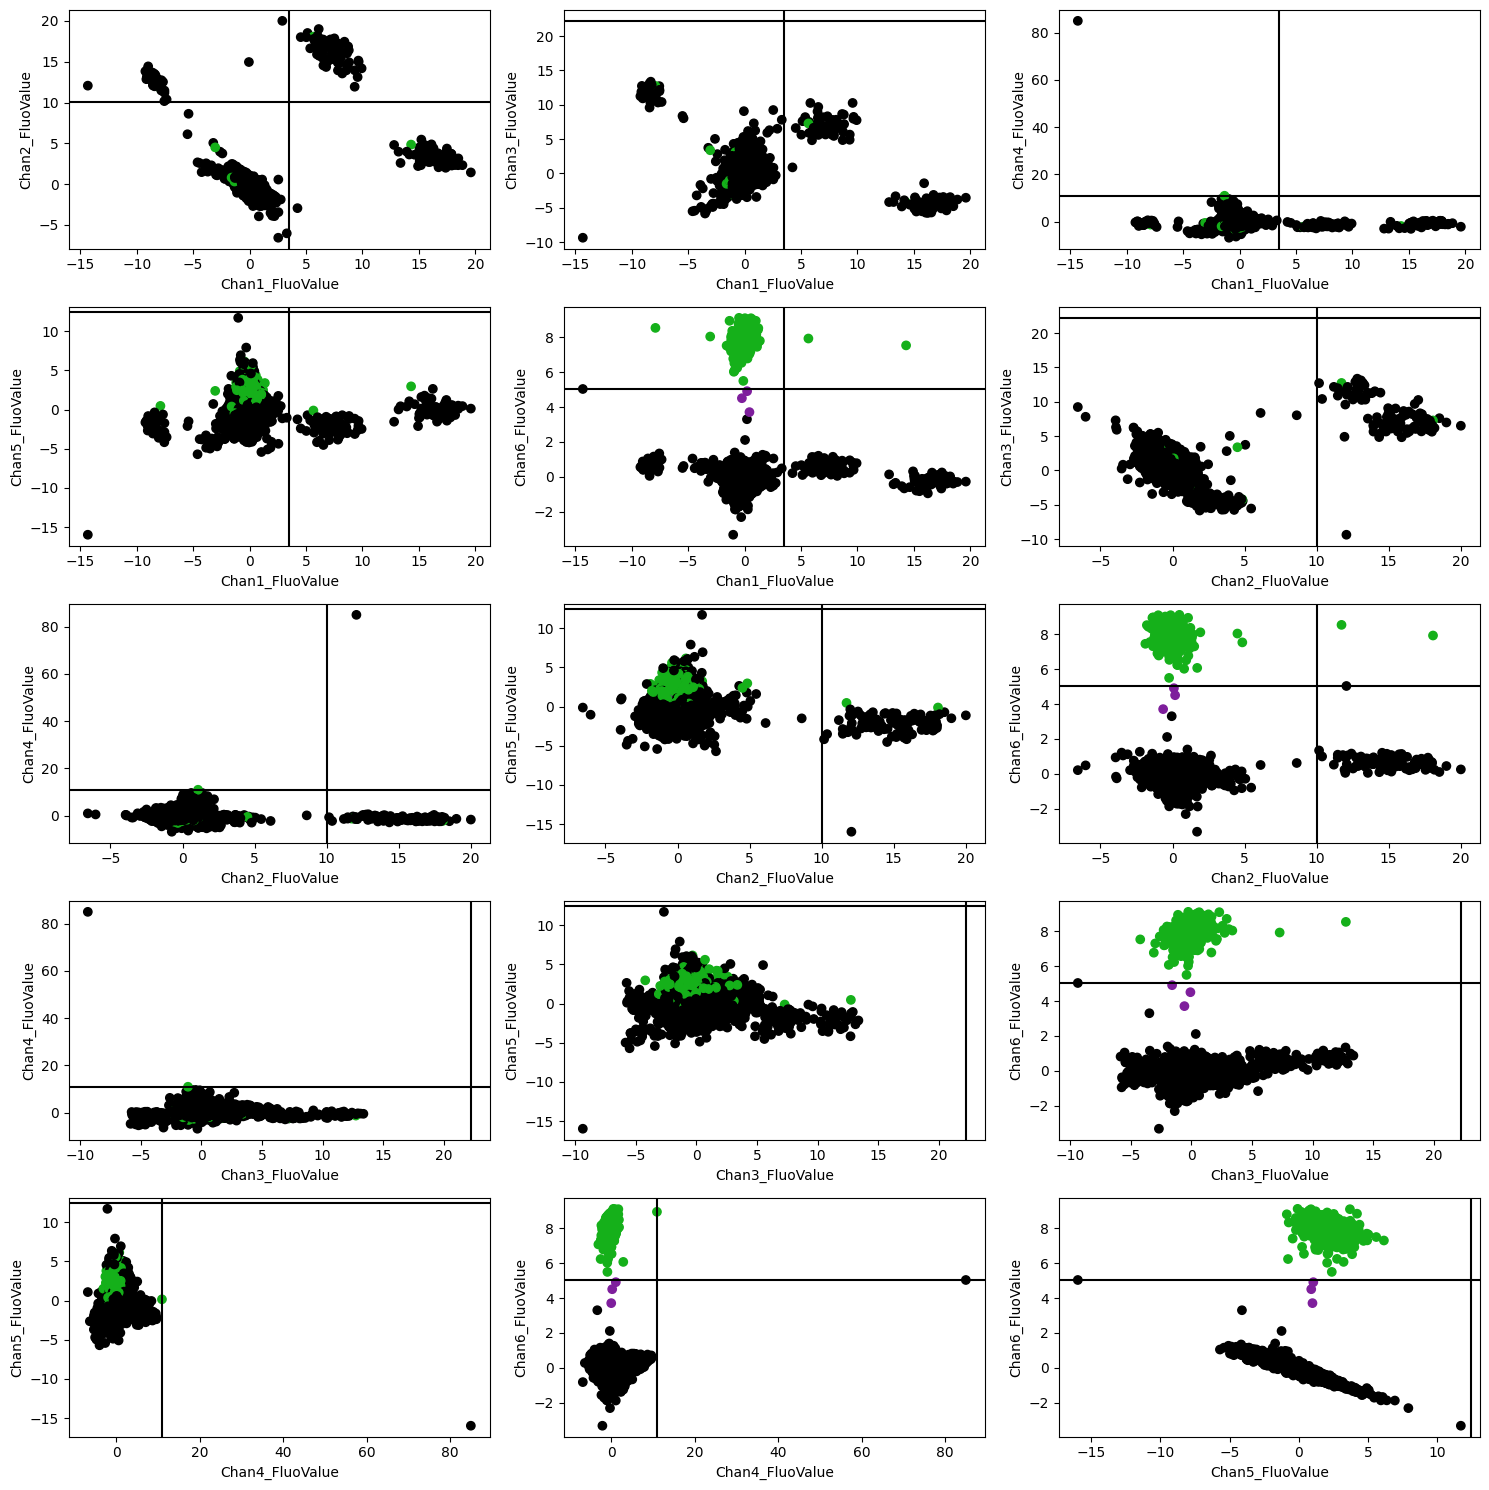

In [12]:
plot_lib.pairwise_plots_pred_true_thresh(pd.DataFrame(data=neg_cluster_based_classifier.X_transformed, columns=df_wa.iloc[:,:6].columns),
                                         df_predictions["MHV_POS"],
                                         df_wa.loc[:,"MHV_POS"],
                                         axis_thresh=neg_cluster_based_classifier.axis_threshholds,
                                         )